In [64]:
#  Organize the data in a way suitable to use for statistics.

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import nan

# ------ LOAD data-tables ---------------------------------------------------- 
# List of clinical table with features and timepoints
# path_Klinisk  = ClinicalData_Klinisk.csv              - Patients list and clinical data
# path_Oversikt = ClinicalData_Oversikt.csv             - Sample list and some measurements at that timepoint
# path_Lipopro  = Lipoproteinene_Combined2.csv          - Lipoprotein measurements (Sample)
# path_Metabol  = Metabolittene_comb_final_clean.csv    - Metabolomics measurments (Sample)

path_Klinisk  = "/Users/mattesa/molbreastlab-storage/work/Radiation_study/Matteo/ClinicalData_Klinisk.csv" 
path_Oversikt = "/Users/mattesa/molbreastlab-storage/work/Radiation_study/Matteo/ClinicalData_Oversikt.csv" 
path_Lipopro  = "/Users/mattesa/molbreastlab-storage/work/Radiation_study/Matteo/Lipoproteinene_Combined2.csv" 
path_Metabol  = "/Users/mattesa/molbreastlab-storage/work/Radiation_study/Matteo/Metabolittene_comb_final_clean.csv" 

root_path = os.path.dirname(path_Lipopro)
             
# Load clinical data file: it contains all the metadata on medications, 
# treatments, sample collection timepoints etc...
# Specifically, load the sheets "Oversikt" and "Klinik fra Randi"
CD_klinisk = pd.read_csv( path_Klinisk,  header=1, index_col=False)
CD_oversik = pd.read_csv( path_Oversikt, header=0, index_col=False)
   
# Load Lipoprotein measurments file: it contains all the measurments for all 
# the blood plasma lipoproteins (only). 
# NOTE: There are some redundant columns
LP_measure = pd.read_csv( path_Lipopro, header=0, index_col=False)
MB_measure = pd.read_csv( path_Metabol, header=0, index_col=False)


# ------ PRUNING the data ----------------------------------------------------
# Extract the timepoints as defined by Guro, but also the date itself, which 
# can be used to pairs entries in different tables.
#result = pd.merge(left, right, on="key")
sele_oversik  = [ "PatientID", 
                  "Samplenames lipo", "Names date modified", "Samling date", 
                  "Dato stråleterapi", "Timepoint", "Timepoint_kodet" ]
CD_samples  = CD_oversik.loc[:,sele_oversik]

#Simplify the names of the Metabolites dataframe columns
names = MB_measure.columns
MB_measure.columns = [xx.split(" (RawConc)")[0] for xx in names]

# Rename column "Samplenames lipo" in CD_oversik === "name" in LP_measure
CD_samples = CD_samples.rename(columns={"Samplenames lipo": "Samplename"})
LP_measure = LP_measure.rename(columns={"name": "Samplename"})
MB_measure = MB_measure.rename(columns={"Sample Name": "Samplename"})

# Insert a "PatientID" column in LP and MB dataframes (redundant but good practice)
LP_measure.insert( loc=1, column="PatientID", value=CD_samples["PatientID"])
MB_measure.insert( loc=1, column="PatientID", value=CD_samples["PatientID"])



# -> Ensure that dataframes contains list of same samples, using "Samplename"
#    to select them and remove the "extra" ones. Specifically, LP_measure  
#    have less samples than MP_measure and CD_samples
#    NOTE: check manually on the list what we are actually removing !!!
# Do set-difference to find missing samples in LP_measure, then a second time 
# to remove them from the list. Then, subset DFs selecting only common samples
miss_nn = np.setdiff1d( CD_samples["Samplename"], LP_measure["Samplename"])
list_nn = np.setdiff1d( CD_samples["Samplename"], miss_nn )
CD_samples = CD_samples.loc[CD_samples["Samplename"].isin(list_nn)]

# As abovem, but btween LP_measure and MB_measure
# NOTE: MB_measure has repeated measurments for a couple of smaples !!!
miss_nn = np.setdiff1d( MB_measure["Samplename"], LP_measure["Samplename"])
list_nn = np.setdiff1d( MB_measure["Samplename"], miss_nn )
MB_measure = MB_measure.loc[MB_measure["Samplename"].isin(list_nn)]

# Remove quality control measurments: string value starting with "QC"
mask_QC = ["QC" not in xx   for xx in LP_measure["Samplename"]]
CD_samples = CD_samples.loc[ mask_QC, : ]
LP_measure = LP_measure.loc[ mask_QC, : ]
MB_measure = MB_measure.loc[ mask_QC, : ]



# At this point we should have the exact same entries in both DataFrames. 
# We can sort-by name columns "Samplename" and "name" should be
# equivalent in both tables
CD_samples = CD_samples.sort_values("Samplename")
LP_measure = LP_measure.sort_values("Samplename")
MB_measure = MB_measure.sort_values("Samplename")

# Some timepoints are uncategorized, and must be removed
mask = CD_samples["Timepoint_kodet"].isnull().values
CD_samples = CD_samples.loc[ ~mask, : ]
LP_measure = LP_measure.loc[ ~mask, : ]
MB_measure = MB_measure.loc[ ~mask, : ]

# Now that we have same order and have sorted tables, we can reindex both.
# Thus, both are sorted and have same row index
CD_samples = CD_samples.reset_index(drop=True)
LP_measure = LP_measure.reset_index(drop=True)
MB_measure = MB_measure.reset_index(drop=True)

# ------ SAVE ----------------------------------------------------------------
# Save as Python-Ready .csv file
LP_measure.to_csv( root_path + "/PyR_Lipoproteine.csv", header=True, index=True)
CD_samples.to_csv( root_path + "/PyR_Sample_Timepoints.csv"  , header=True, index=True)

In [142]:
import sys
# Add as desired to the list of known working paths for Python 
sys.path.append('F:/Python/')

import mbc_PLS_basic
from mbc_PLS_basic import *
# Force reload during development, otherwise Python only loads first time 
# and does not update unless the kernel is rebooted
# import importlib
# importlib.reload(mbc_PLS_basic)


# --- 0 --- Parameters for the cross validation ------------------------------
max_N_comp = 10           # Maximum number of components to tes
outer_PropSele = 0.20     # proportion train-to-test to use
inner_PropSele = 0.20    
outer_loop  = 10          # cycles number to perform double cross val.
inner_loop  = 10
min_cat = 1
max_cat = 5

# Transform categories into 0 and 1 response values
transform_cat = True
if transform_cat == True :
    min_rval = 0
    max_rval = 1
    p_threshold = 0.5                       # predicted probability threshold
else:
    min_rval = min_cat
    max_rval = max_cat
    p_threshold = (min_cat+max_cat) / 2     # predicted probability threshold


# Column name for the response variable to use in PLS-DA
unique_PatientID_Col = "PatientID"
Response_Col         = "Timepoint_kodet"


# --- 1 --- Prepare the DataFrames in the appropriate format -----------------
# Prepare the data we wish to use for the PLS model in XX and YY dataframes.
# Scale-standardize the XX matrix and reduce selection only for data with 
# specific values in "Response_Col" column (min_cat, max_cat)
YY = CD_samples.copy()
dataset = MB_measure         # pd.concat([LP_measure, MB_measure.iloc[:,2:]], axis = 1)

XX_vars_scaled, XX_scaled = StandardScale_FeatureTable( dataset , 2)
XX, YY = CrossSelect_TwoTables( XX_vars_scaled, YY, Response_Col, [min_cat,max_cat], transform_cat ) 



# --- 2 --- Cross-validation of PLS ------------------------------------------
accuracy, comparPred, outerMSE, innerMSE = optimise_PLS_CrossVal(
                                              XX, YY, max_N_comp, unique_PatientID_Col,
                                              Response_Col, min_rval, max_rval, p_threshold , 
                                              outer_loop, inner_loop, outer_PropSele, inner_PropSele,
                                              False)

accuracy["Mean"] = accuracy.mean(axis=1)
accuracy

,o1,o2,o3,o4,o5,o6,o7,o8,o9,o10,Mean
Best_nLV,8.000000,6.000000,10.000000,9.000000,10.000000,10.000000,6.000000,10.000000,7.000000,8.000000,8.400000
Accuracy,0.851351,0.862500,0.800000,0.820513,0.831325,0.826667,0.881579,0.826667,0.824324,0.794118,0.831904
Specificity,0.226316,0.239362,0.239362,0.259459,0.252688,0.266304,0.232804,0.239362,0.252688,0.232804,0.244115
Selectivity,0.267241,0.312500,0.256410,0.256410,0.324324,0.214876,0.278261,0.256410,0.225000,0.195122,0.258656


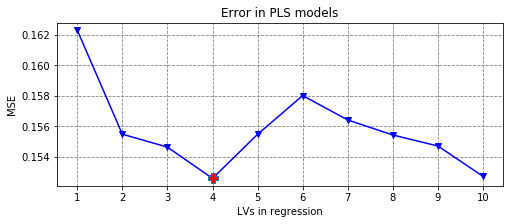

In [59]:
plot_metrics(outerMSE.iloc[ 0:1, :].T.values, 'MSE', 'min')

In [ ]:
# --- 3 --- Final PLS model --------------------------------------------------

X_scores, Y_scores, X_loads, Y_loads = PLS_fit_model( XX, YY.loc[:, Response_Col], 5, Response_Col)

# --- 4 --- Plot SCORES by Response_Col --------------------------------------

# Create a table with all that we need for plotting the desired results 
DF_scores = X_scores.copy() 
DF_scores[Response_Col] = np.array(YY.loc[:, Response_Col])

# We create a 2D scatter plot, we only need to take the first two latent 
# variables and the response column (the last). We color each category 
# (targets) with a unique color
plotDF = DF_scores.iloc[:,[0,1,-1]]

targets = np.sort( YY.loc[:, Response_Col].unique() )
colors  = ['r', 'g', 'b', 'k', 'm', 'c', 'o']

fig = plt.figure(figsize = (8,8))
ax  = fig.add_subplot(1,1,1) 

# Plot the PCA in as 2D scatterplot and uniquely  color each flowcell data
for target, color in zip(targets,colors):
    ind_xx = plotDF[Response_Col] == target
    ax.scatter( plotDF.loc[ind_xx, plotDF.columns[0]], 
                plotDF.loc[ind_xx, plotDF.columns[1]], 
                c = color,
                s = 20)
plt.grid(color = "grey", linestyle='--')
ax.set_xlabel('Score on LV 1', fontsize = 15)
ax.set_ylabel('Score on LV 2', fontsize = 15)
ax.set_title('PLS-DA on '+ Response_Col , fontsize = 20)
if transform_cat == True :     ax.legend([min_cat,max_cat] )
else:                          ax.legend(targets)
nn = 15
ax.set_xlim([-nn, nn])
ax.set_ylim([-nn, nn])

# --- SAVE the plot ----------------------------------------------------------
# plt.savefig(root_path + "/Figures/PLSDA_LP-MB_"+str(min_cat)+"_"+str(max_cat)+".svg")

In [ ]:
# --- 3 --- Final PLS model --------------------------------------------------

X_scores, Y_scores, X_loads, Y_loads = PLS_fit_model( XX, YY.loc[:, Response_Col], 5, Response_Col)

# --- 5 --- Plot LOADING -----------------------------------------------------

# Create a table with all that we need for plotting the desired results 
DF_scores = X_loads.copy() 

# We create a 2D scatter plot, we only need to take the first two latent 
# variables and the response column (the last). We color each category 
# (targets) with a unique color
plotDF = DF_scores.iloc[:,[0,1]]

fig = plt.figure(figsize = (8,8))
ax  = fig.add_subplot(1,1,1) 

# Plot the PCA in as 2D scatterplot and uniquely  color each flowcell data
ax.scatter( plotDF.loc[:, plotDF.columns[0]], 
            plotDF.loc[:, plotDF.columns[1]], 
            c = 'r',
            s = 20)

# Plot unit circle
circ = plt.Circle((0, 0), radius=1,   edgecolor='black', linestyle='--', facecolor='None')
ax.add_patch(circ)
circ = plt.Circle((0, 0), radius=0.5, edgecolor='grey',  linestyle='--', facecolor='None')
ax.add_patch(circ)
#ax.plot(np.cos(t), np.sin(t), linewidth=1)

plt.grid(color = "grey", linestyle='--')
ax.set_xlabel('Load on LV 1', fontsize = 15)
ax.set_ylabel('Load on LV 2', fontsize = 15)
ax.set_title('PLS-DA on '+ Response_Col , fontsize = 20)
nn = 1.1
ax.set_xlim([-nn, nn])
ax.set_ylim([-nn, nn])


# --- SAVE the plot ----------------------------------------------------------
plt.savefig(root_path + "/Figures/PLSDA_load_MB_"+str(min_cat)+"_"+str(max_cat)+".svg")

In [ ]:
## AA = pd.DataFrame( data = { "C1":[0,1,2,3,4,5,6,7,8,9],
                            "C2":[0,1,2,3,4,5,6,7,8,9],
                            "C3":["0","1","2","3","4","5","6","7","8","9"],
                            "C4":["0","1","2","3","4","5","6","7","8","9"]  
                          } )

BB = pd.DataFrame( data = { "C1":[0,1,2,3,4,5,6,7,8,9],
                            "C2":[0,1,1,3,3,5,5,7,7,0],
                            "C3":["0","1","2","3","4","5","6","7","8","9"],
                            "C4":["2","2","4","4","6","6","7","7","8","8"]  
                           } )

comparison = [ qq == ee for qq,ee in zip( AA["C1"], BB["C2"]) ]

#if   np.all(equality_check):
    # All values between the two columns are equal
    
#elif np.any(equality_check):
    # Only some values between columns are equal


# check uniqueness of lists

train_pID = np.setdiff1d( uID_List, test_pID )
train_idx = np.where( M_Y[uID_colname].isin( train_pID ))[0].tolist()


check_all = np.all(equality_check)
idx = np.where(comparison)[0].tolist()
idx

In [124]:
X_loads

,Load_X_LV_1,Load_X_LV_2,Load_X_LV_3,Load_X_LV_4,Load_X_LV_5
TPTG [mg/dL],0.198680,-0.186094,0.148967,0.052644,-0.014581
TPCH [mg/dL],-0.163663,0.010694,0.179448,0.139520,0.003656
LDCH [mg/dL],-0.252461,0.087704,0.137967,0.107761,-0.036999
HDCH [mg/dL],-0.162275,0.060790,0.035022,-0.064525,0.187942
TPA1 [mg/dL],-0.112575,0.037465,0.104676,0.017529,0.154575
...,...,...,...,...,...
Glucose,0.043275,-0.057723,0.017093,0.069789,0.068558
Glycerol,-0.060928,-0.075393,-0.000843,0.178361,0.023821
Dimethylsulfone,0.015135,-0.024269,0.034659,-0.001739,-0.054479
Ca-EDTA,-0.008525,-0.000306,0.009941,0.036100,0.000954
